In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Reading in the Data

In [3]:
yac_data = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/01_score_arrived/outputs/pass_complete_training_tensor.csv")

In [4]:
yac_data.head(20)

,group,gameId,playId,defense_nflId,offense_nflId,playId3,playId2,defenseId,offenseId,defense_s_x,...,defense_offense_x,defense_offense_y,defense_offense_s_x,defense_offense_s_y,receiver_s_x,receiver_s_y,receiver_distance_from_los,defense_football_x,defense_football_y,football_s
0,test,2018090600,320,2539334,2507763,3,1,1,1,3.670185,...,5.98,4.15,2.753904,6.445801,-0.057682,6.609748,3.63,10.91,-32.93,20.29
1,test,2018090600,320,2539334,2532842,3,1,1,2,3.670185,...,19.06,-19.85,3.816364,0.858249,-0.057682,6.609748,3.63,10.91,-32.93,20.29
2,test,2018090600,320,2539334,2540158,3,1,1,3,3.670185,...,8.45,-28.46,4.188877,-3.276158,-0.057682,6.609748,3.63,10.91,-32.93,20.29
3,test,2018090600,320,2539334,2552582,3,1,1,4,3.670185,...,11.04,-18.73,1.064861,0.866509,-0.057682,6.609748,3.63,10.91,-32.93,20.29
4,test,2018090600,320,2539334,2553502,3,1,1,5,3.670185,...,6.36,-8.37,2.882241,4.340380,-0.057682,6.609748,3.63,10.91,-32.93,20.29
5,test,2018090600,320,0,0,3,1,1,6,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
6,test,2018090600,320,0,0,3,1,1,7,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
7,test,2018090600,320,0,0,3,1,1,8,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
8,test,2018090600,320,0,0,3,1,1,9,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
9,test,2018090600,320,0,0,3,1,1,10,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00


In [5]:
yac_data.shape

(2432540, 25)

In [6]:
target_data = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/01_score_arrived/outputs/pass_complete_training_target.csv")

In [7]:
target_data.head(10)

,group,gameId,playId,playId2,playId3,offensePlayResult,offensePlayResult_adj
0,test,2018090600,320,1,3,4,4
1,test,2018090600,492,2,4,26,26
2,test,2018090600,1202,3,12,3,3
3,test,2018090600,1916,4,20,7,7
4,test,2018090600,2575,5,25,6,6
5,test,2018090600,3791,6,33,-5,-5
6,test,2018090600,3950,7,36,9,9
7,test,2018090600,4166,8,39,36,36
8,test,2018090600,4282,9,41,9,9
9,test,2018090900,186,10,45,29,29


# Formatting the Data

In [8]:
yac_data.columns

Index(['group', 'gameId', 'playId', 'defense_nflId', 'offense_nflId',
       'playId3', 'playId2', 'defenseId', 'offenseId', 'defense_s_x',
       'defense_s_y', 'defense_receiver_x', 'defense_receiver_y',
       'defense_receiver_s_x', 'defense_receiver_s_y', 'defense_offense_x',
       'defense_offense_y', 'defense_offense_s_x', 'defense_offense_s_y',
       'receiver_s_x', 'receiver_s_y', 'receiver_distance_from_los',
       'defense_football_x', 'defense_football_y', 'football_s'],
      dtype='object')

In [9]:
def create_x(data, nfeatures):
    # creating a numpy tensor to hold the play data
    np_mat = np.array(data.drop(['group', 'gameId', 'playId', 'playId3','defense_nflId', 'offense_nflId'],
                               axis = 1))
    
    # setting parameters
    ngames = np.max(np.array(data['playId2']))
    nDef = 11
    nOff = 10
    
    # initializing the tensor
    np_tensor = np.zeros((ngames, nDef, nOff, nfeatures))
    
    for row in range(len(np_mat)):
        np_tensor[int(np_mat[row][0]) - 1][int(np_mat[row][1]) - 1][int(np_mat[row][2]) - 1] = np_mat[row][3:]
    
    np_tensor = np_tensor.astype('float32')
    
    return(np_tensor)

In [10]:
X_train = create_x(data = yac_data[yac_data["group"] == "training"],
                  nfeatures = 16)

In [11]:
X_train.shape

(15478, 11, 10, 16)

In [12]:
X_train[0][0][0]

array([  0.8543228,  -7.521638 ,  -1.23     ,   2.69     ,   2.478529 ,
        -3.615891 ,  13.96     , -17.66     ,   0.8669877,  -6.931774 ,
        -1.624206 ,  -3.905746 ,   8.89     ,   0.95     ,   1.29     ,
        12.68     ], dtype=float32)

In [13]:
X_validation = create_x(data = yac_data[(yac_data["group"] == "validation")&(yac_data["gameId"] < 20000000000)],
                  nfeatures = 16)

In [14]:
X_validation.shape

(1659, 11, 10, 16)

In [15]:
X_validation[0][0][0]

array([  3.09092  ,  -0.3439712, -10.63     , -12.69     ,  -1.668438 ,
        -6.761807 ,  20.57     ,  -0.17     ,   2.123785 ,  -0.0897068,
         4.759357 ,   6.417836 ,  22.54     ,  -8.48     , -12.87     ,
        14.       ], dtype=float32)

In [16]:
X_test = create_x(data = yac_data[(yac_data["group"] == "test")&(yac_data["gameId"] < 20000000000)],
                  nfeatures = 16)

In [17]:
X_test.shape

(1659, 11, 10, 16)

In [18]:
X_test[0][0][0]

array([  3.6701853,   1.022663 ,   9.1      , -34.8      ,   3.7278678,
        -5.5870852,   5.98     ,   4.15     ,   2.7539036,   6.4458013,
        -0.0576824,   6.6097484,   3.63     ,  10.91     , -32.93     ,
        20.29     ], dtype=float32)

In [19]:
def create_y(data):
    targets = np.array(data["offensePlayResult_adj"])
    
    y = np.zeros((targets.shape[0], 199))
    for idx, target in enumerate(list(targets)):
        y[idx][99 + target] = 1
    
    return(y)

In [20]:
y_train = create_y(data = target_data[(target_data["group"] == "training")])

In [21]:
y_train.shape

(15478, 199)

In [22]:
y_train[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
y_validation = create_y(data = target_data[(target_data["group"] == "validation")&(target_data["gameId"] < 20000000000)])

In [24]:
y_validation.shape

(1659, 199)

In [25]:
y_test = create_y(data = target_data[(target_data["group"] == "test") & (target_data["gameId"] < 20000000000)])

In [26]:
y_test.shape

(1659, 199)

In [27]:
y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Training a Convolutional Neural Network Model

In [28]:
model = tf.keras.Sequential()

In [29]:
# first convolutional neural network
model.add(layers.Conv2D(128, 
                        kernel_size=(1,1), 
                        strides=(1,1), 
                        input_shape = (11,10,16)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(160, 
                        kernel_size=(1,1), 
                        strides=(1,1)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(128, 
                        kernel_size=(1,1), 
                        strides=(1,1)))
model.add(layers.Activation('relu'))

import tensorflow.keras.backend as K

def channelPool(x):
    return .5*K.max(x,axis=2) + .5*K.mean(x,axis=2)

model.add(layers.Lambda(channelPool))

In [30]:
# second convolutional neural network
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(160, 
                        kernel_size=1, 
                        strides=1))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(196, 
                        kernel_size=1, 
                        strides=1))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv1D(196, 
                        kernel_size=1, 
                        strides=1))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
# model.add(layers.AvgPool2D(pool_size=(11, 1)))

def channelPool(x):
    return .5*K.max(x,axis=1) + .5*K.mean(x,axis=1)

model.add(layers.Lambda(channelPool))

In [31]:
model.add(layers.Flatten())
model.add(layers.Dense(96))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256))
model.add(layers.Activation('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(199))
model.add(layers.Activation('softmax'))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 11, 10, 128)       2176      
_________________________________________________________________
activation (Activation)      (None, 11, 10, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 10, 160)       20640     
_________________________________________________________________
activation_1 (Activation)    (None, 11, 10, 160)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 10, 128)       20608     
_________________________________________________________________
activation_2 (Activation)    (None, 11, 10, 128)       0         
_________________________________________________________________
lambda (Lambda)              (None, 11, 128)           0

In [33]:
import tensorflow.keras.backend as K
def crps(y_true, y_pred):
    y_pred =  K.cumsum(y_pred, axis=1)
    ym =  K.cast(K.reshape(K.argmax(y_true, axis=1) - 99, (-1, 1)), 
        dtype='int32')
    n = K.arange(-99, 100)
    step = K.cast(K.greater_equal(n - ym, 0), dtype='float32')
    return K.mean(K.sum(K.square(y_pred - step), axis=1)) / 199

In [34]:
from tensorflow.keras.callbacks import EarlyStopping,  ModelCheckpoint

In [35]:
from tensorflow.keras.optimizers import Adam
model.compile(loss=[crps], metrics=[crps], optimizer='adam')

In [36]:
history = model.fit(X_train, y_train,
                   validation_data = (X_validation, y_validation),
                   # batch_size = 64,
                   epochs = 20,
                   verbose = 1)

Epoch 1/20
484/484 [==============================] - 16s 33ms/step - loss: 0.0216 - crps: 0.0216 - val_loss: 0.0162 - val_crps: 0.0162
Epoch 2/20
484/484 [==============================] - 23s 48ms/step - loss: 0.0151 - crps: 0.0151 - val_loss: 0.0147 - val_crps: 0.0147
Epoch 3/20
484/484 [==============================] - 20s 42ms/step - loss: 0.0142 - crps: 0.0142 - val_loss: 0.0142 - val_crps: 0.0142
Epoch 4/20
484/484 [==============================] - 17s 35ms/step - loss: 0.0136 - crps: 0.0136 - val_loss: 0.0138 - val_crps: 0.0138
Epoch 5/20
484/484 [==============================] - 23s 48ms/step - loss: 0.0133 - crps: 0.0133 - val_loss: 0.0126 - val_crps: 0.0126
Epoch 6/20
484/484 [==============================] - 17s 35ms/step - loss: 0.0130 - crps: 0.0130 - val_loss: 0.0121 - val_crps: 0.0121
Epoch 7/20
484/484 [==============================] - 17s 36ms/step - loss: 0.0126 - crps: 0.0126 - val_loss: 0.0118 - val_crps: 0.0119
Epoch 8/20
484/484 [============================

In [37]:
model.evaluate(X_test, y_test)

52/52 [==============================] - 1s 14ms/step - loss: 0.0120 - crps: 0.0120


[0.011979040689766407, 0.011973220854997635]

# Examining Results

The plays analyzed are part of the holdout set, so the CNN model did not ever see the data in training, or indirectly through optimizing the crps of the cross-validation set.

### Play that Went For Negative Yardage

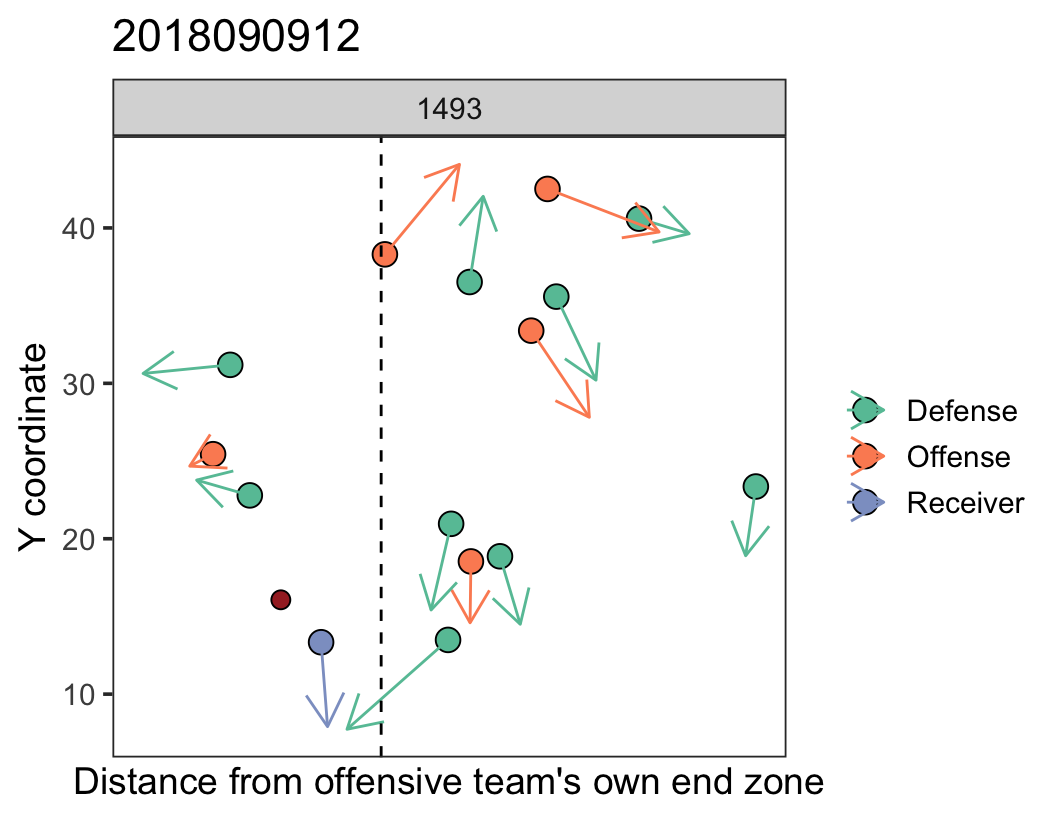

In [38]:
yac_data[(yac_data["gameId"] == 2018090912) & (yac_data["playId"] == 1493)]["playId2"].iloc[0]

68

In [39]:
yards = target_data[(target_data["gameId"] == 2018090912) & (target_data["playId"] == 1493)]["offensePlayResult"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a -2 gain.


In [40]:
np.argmax(y_test[68-1]) - 99

-2

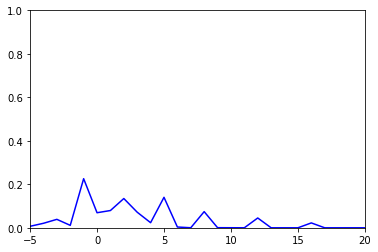

In [41]:
plt.plot(np.arange(-99,100), model.predict(X_test)[67], 'b-')
plt.xlim(-5,20)
plt.ylim(0,1)
plt.show()

In [42]:
# yardage prediction
model.predict(X_test)[67].dot(np.arange(-99,100))

2.620769046004625

### Play that Went For No Yardage

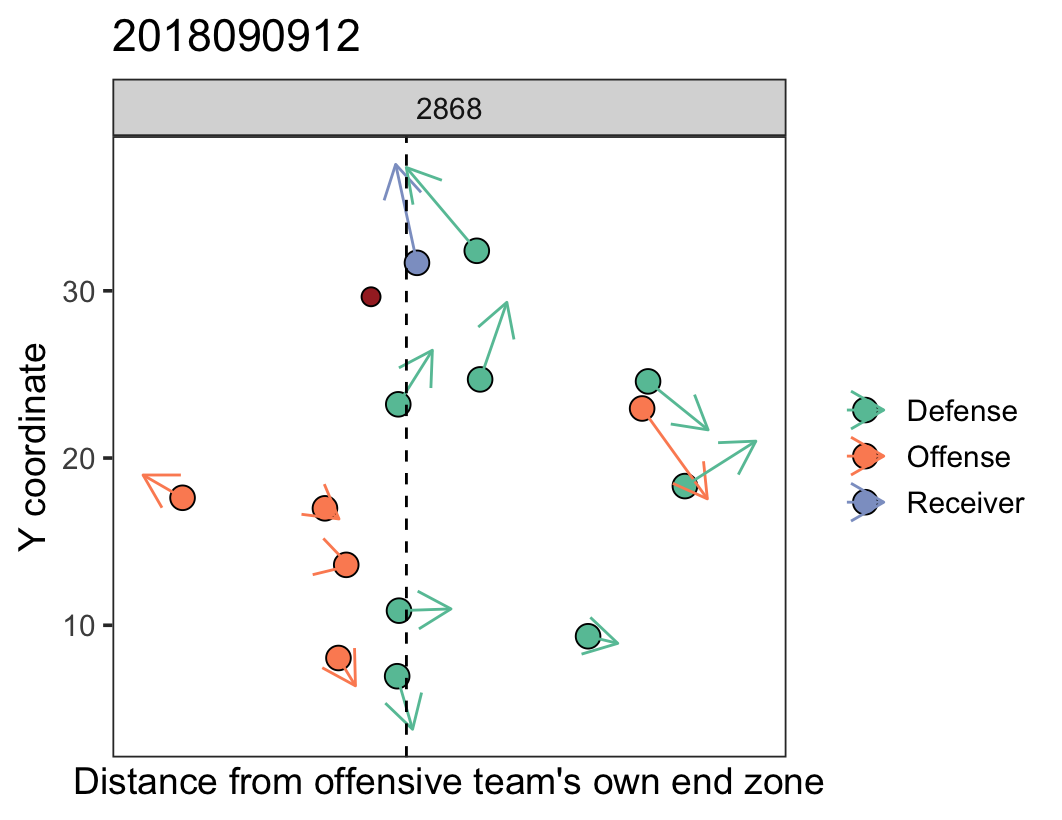

In [48]:
yac_data[(yac_data["gameId"] == 2018090912) & (yac_data["playId"] == 2868)]["playId2"].iloc[0]

73

In [49]:
yards = target_data[(target_data["gameId"] == 2018090912) & (target_data["playId"] == 2868)]["offensePlayResult"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a 0 gain.


In [50]:
np.argmax(y_test[73-1]) - 99

0

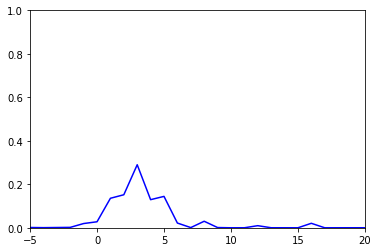

In [51]:
plt.plot(np.arange(-99,100), model.predict(X_test)[72], 'b-')
plt.xlim(-5,20)
plt.ylim(0,1)
plt.show()

In [52]:
# yardage prediction
model.predict(X_test)[72].dot(np.arange(-99,100))

3.5864063572921623

### Play that Went For 10 Yards

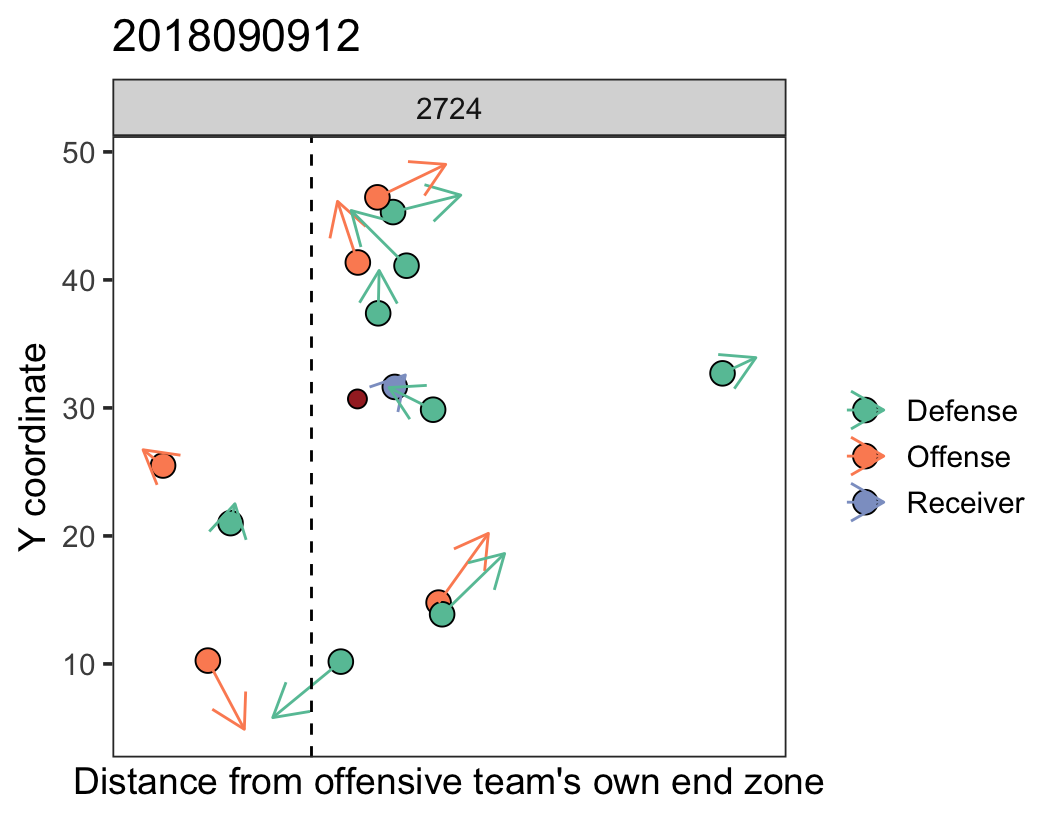

In [53]:
yac_data[(yac_data["gameId"] == 2018090912) & (yac_data["playId"] == 2724)]["playId2"].iloc[0]

72

In [54]:
yards = target_data[(target_data["gameId"] == 2018090912) & (target_data["playId"] == 2724)]["offensePlayResult"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a 10 gain.


In [55]:
np.argmax(y_test[72-1]) - 99

10

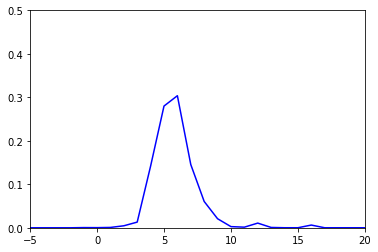

In [56]:
plt.plot(np.arange(-99,100), model.predict(X_test)[71], 'b-')
plt.xlim(-5,20)
plt.ylim(0,.5)
plt.show()

In [57]:
# yardage prediction
model.predict(X_test)[71].dot(np.arange(-99,100))

5.934953019127306

### Play that Went For 30+ Yards

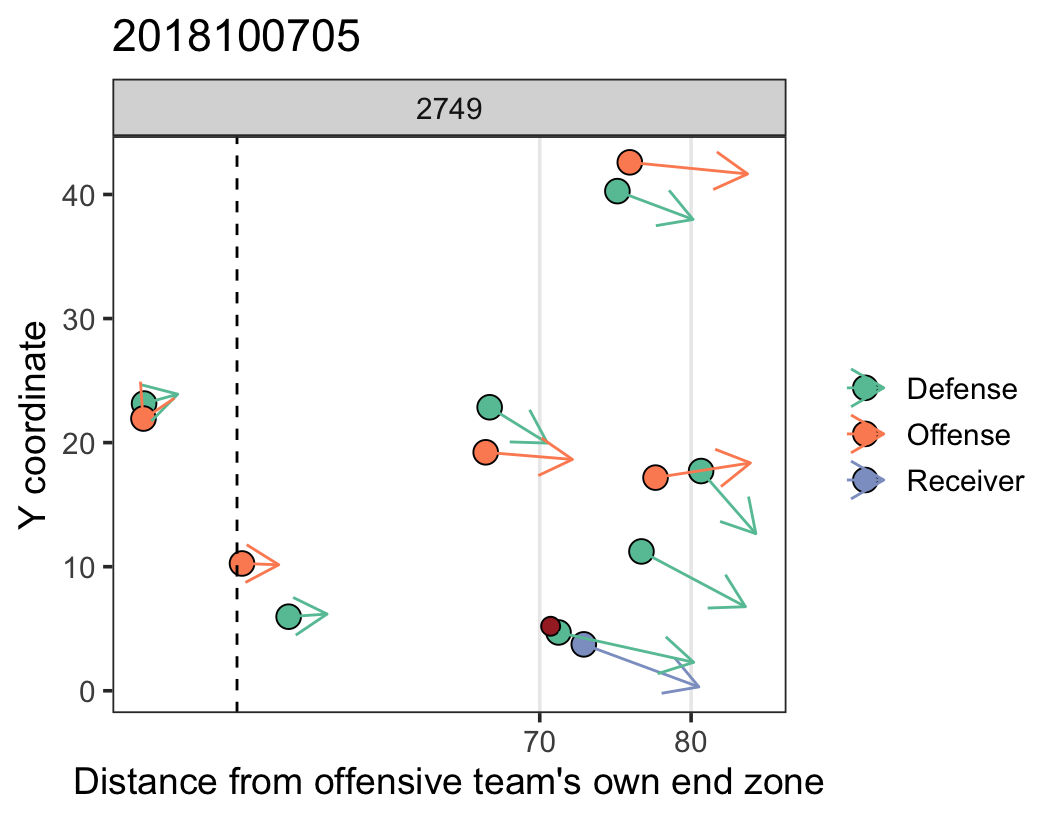

In [58]:
yac_data[(yac_data["gameId"] == 2018100705) & (yac_data["playId"] == 2749)]["playId2"].iloc[0]

472

In [59]:
yards = target_data[(target_data["gameId"] == 2018100705) & (target_data["playId"] == 2749)]["offensePlayResult"].iloc[0]
print("The actual result of the play was a " + str(yards) + " gain.")

The actual result of the play was a 30 gain.


In [60]:
np.argmax(y_test[472-1]) - 99

30

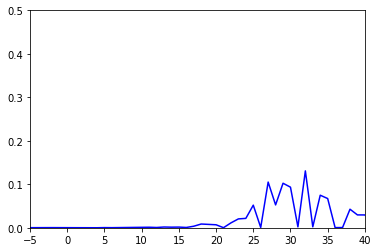

In [61]:
plt.plot(np.arange(-99,100), model.predict(X_test)[471], 'b-')
plt.xlim(-5,40)
plt.ylim(0,.5)
plt.show()

In [62]:
# yardage prediction
model.predict(X_test)[471].dot(np.arange(-99,100))

31.86822570505319

# Scoring Entire Data Set

In [63]:
pass_arrived_score = pd.read_csv("~/Desktop/CoverageNet/src/03_coverageNet/01_score_arrived/outputs/pass_arrived_score_tensor.csv")

In [64]:
pass_arrived_score.head(20)

,group,gameId,playId,defense_nflId,offense_nflId,playId2,defenseId,offenseId,defense_s_x,defense_s_y,...,defense_offense_s_x,defense_offense_s_y,receiver_s_x,receiver_s_y,receiver_distance_from_los,defense_football_x,defense_football_y,football_s,receiver_football_defender_dist_diff,defender_receiver_football_dist_diff
0,full,2018090600,75,79848,310,1,1,1,0.854323,-7.521638,...,0.866988,-6.931774,-1.624206,-3.905746,8.89,0.95,1.29,12.68,-0.367041,-0.988769
1,full,2018090600,75,79848,2533040,1,1,2,0.854323,-7.521638,...,-1.580489,-5.786186,-1.624206,-3.905746,8.89,0.95,1.29,12.68,-0.367041,-0.988769
2,full,2018090600,75,79848,2543583,1,1,3,0.854323,-7.521638,...,-2.652919,-5.933634,-1.624206,-3.905746,8.89,0.95,1.29,12.68,-0.367041,-0.988769
3,full,2018090600,75,79848,2555415,1,1,4,0.854323,-7.521638,...,-1.216309,-14.260702,-1.624206,-3.905746,8.89,0.95,1.29,12.68,-0.367041,-0.988769
4,full,2018090600,75,79848,2559033,1,1,5,0.854323,-7.521638,...,-0.722724,-14.146517,-1.624206,-3.905746,8.89,0.95,1.29,12.68,-0.367041,-0.988769
5,full,2018090600,75,0,0,1,1,6,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000
6,full,2018090600,75,0,0,1,1,7,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000
7,full,2018090600,75,0,0,1,1,8,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000
8,full,2018090600,75,0,0,1,1,9,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000
9,full,2018090600,75,0,0,1,1,10,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00,0.000000,0.000000


In [65]:
pass_arrived_score.shape

(1558590, 26)

In [66]:
pass_arrived_score2 = pass_arrived_score.drop(['receiver_football_defender_dist_diff', 
                                                'defender_receiver_football_dist_diff'],
                                            axis = 1)

In [67]:
pass_arrived_score2.head(20)

,group,gameId,playId,defense_nflId,offense_nflId,playId2,defenseId,offenseId,defense_s_x,defense_s_y,...,defense_offense_x,defense_offense_y,defense_offense_s_x,defense_offense_s_y,receiver_s_x,receiver_s_y,receiver_distance_from_los,defense_football_x,defense_football_y,football_s
0,full,2018090600,75,79848,310,1,1,1,0.854323,-7.521638,...,13.96,-17.66,0.866988,-6.931774,-1.624206,-3.905746,8.89,0.95,1.29,12.68
1,full,2018090600,75,79848,2533040,1,1,2,0.854323,-7.521638,...,-4.68,-9.66,-1.580489,-5.786186,-1.624206,-3.905746,8.89,0.95,1.29,12.68
2,full,2018090600,75,79848,2543583,1,1,3,0.854323,-7.521638,...,8.79,-14.65,-2.652919,-5.933634,-1.624206,-3.905746,8.89,0.95,1.29,12.68
3,full,2018090600,75,79848,2555415,1,1,4,0.854323,-7.521638,...,-3.99,-28.44,-1.216309,-14.260702,-1.624206,-3.905746,8.89,0.95,1.29,12.68
4,full,2018090600,75,79848,2559033,1,1,5,0.854323,-7.521638,...,4.79,-34.25,-0.722724,-14.146517,-1.624206,-3.905746,8.89,0.95,1.29,12.68
5,full,2018090600,75,0,0,1,1,6,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
6,full,2018090600,75,0,0,1,1,7,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
7,full,2018090600,75,0,0,1,1,8,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
8,full,2018090600,75,0,0,1,1,9,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00
9,full,2018090600,75,0,0,1,1,10,0.000000,0.000000,...,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.00,0.00


In [68]:
pass_arrived_score2.shape

(1558590, 24)

# Formatting the Data

In [69]:
pass_arrived_score.columns

Index(['group', 'gameId', 'playId', 'defense_nflId', 'offense_nflId',
       'playId2', 'defenseId', 'offenseId', 'defense_s_x', 'defense_s_y',
       'defense_receiver_x', 'defense_receiver_y', 'defense_receiver_s_x',
       'defense_receiver_s_y', 'defense_offense_x', 'defense_offense_y',
       'defense_offense_s_x', 'defense_offense_s_y', 'receiver_s_x',
       'receiver_s_y', 'receiver_distance_from_los', 'defense_football_x',
       'defense_football_y', 'football_s',
       'receiver_football_defender_dist_diff',
       'defender_receiver_football_dist_diff'],
      dtype='object')

In [70]:
def create_x(data, nfeatures):
    # creating a numpy tensor to hold the play data
    np_mat = np.array(data.drop(['group', 'gameId', 'playId','defense_nflId', 'offense_nflId'],
                               axis = 1))
    
    # setting parameters
    ngames = np.max(np.array(data['playId2']))
    nDef = 11
    nOff = 10
    
    # initializing the tensor
    np_tensor = np.zeros((ngames, nDef, nOff, nfeatures))
    
    for row in range(len(np_mat)):
        np_tensor[int(np_mat[row][0]) - 1][int(np_mat[row][1]) - 1][int(np_mat[row][2]) - 1] = np_mat[row][3:]
    
    np_tensor = np_tensor.astype('float32')
    
    return(np_tensor)

In [71]:
X_score = create_x(data = pass_arrived_score2,
                  nfeatures = 16)

In [72]:
X_score.shape

(14169, 11, 10, 16)

In [73]:
X_score[0][0][0]

array([  0.85432285,  -7.5216374 ,  -1.23      ,   2.69      ,
         2.4785287 ,  -3.6158912 ,  13.96      , -17.66      ,
         0.8669877 ,  -6.9317737 ,  -1.624206  ,  -3.9057465 ,
         8.89      ,   0.95      ,   1.29      ,  12.68      ],
      dtype=float32)

# Saving Predictions

In [74]:
score_preds = model.predict(X_score)

In [99]:
score_preds[0]

array([4.84409748e-06, 8.79144318e-06, 4.74566787e-06, 2.80835229e-06,
       8.83007851e-06, 5.01927934e-06, 4.77372942e-06, 4.79143091e-06,
       2.07572953e-06, 4.07952029e-06, 3.17798253e-06, 5.29935824e-06,
       4.29518286e-06, 3.57807312e-06, 4.20434071e-06, 2.37687777e-06,
       2.92298523e-06, 2.14803481e-06, 4.40444774e-06, 3.79768221e-06,
       3.55302950e-06, 4.42424653e-06, 2.39189035e-06, 3.55903921e-06,
       2.99513681e-06, 4.73551381e-06, 2.07047447e-06, 6.50987931e-06,
       4.67286873e-06, 5.14708199e-06, 6.18830245e-06, 2.83399208e-06,
       3.89895513e-06, 1.02899094e-05, 5.76194088e-06, 2.99382032e-06,
       3.53744645e-06, 3.04721948e-06, 6.12184340e-06, 3.22144706e-06,
       3.02715830e-06, 4.91843912e-06, 3.57331282e-06, 6.00977182e-06,
       4.13975840e-06, 4.92718982e-06, 2.04638786e-06, 3.41241480e-06,
       2.47970729e-06, 3.61146067e-06, 3.21678067e-06, 5.15265629e-06,
       3.25659926e-06, 4.05474339e-06, 2.39895371e-06, 2.81797816e-06,
      

In [76]:
full_preds_df = pd.DataFrame(score_preds, columns = [str(int(x - 99)) for x in np.linspace(0,198, 199)])

In [77]:
full_preds_df.shape

(14169, 199)

In [93]:
full_preds_df2 = pd.concat([pass_arrived_score2[["gameId","playId"]].drop_duplicates().reset_index(), full_preds_df], axis = 1)
full_preds_df2 = full_preds_df2[full_preds_df2["gameId"] < 10000000000]
full_preds_df2 = full_preds_df2.drop(['index'], axis = 1)

In [94]:
full_preds_df2.shape

(14169, 201)

In [95]:
full_preds_df2.head(10)

,gameId,playId,-99,-98,-97,-96,-95,-94,-93,-92,...,90,91,92,93,94,95,96,97,98,99
0,2018090600,75,4.844097e-06,8.791443e-06,4.745668e-06,2.808352e-06,8.830079e-06,5.019279e-06,4.773729e-06,4.791431e-06,...,0.000009,0.000005,6.046554e-06,0.000004,3.785699e-06,0.000010,5.579991e-06,0.000008,0.000003,0.000005
1,2018090600,146,6.353093e-07,1.564784e-06,7.732727e-07,5.009244e-07,1.179622e-06,8.137571e-07,4.790739e-07,1.234141e-06,...,0.000002,0.000003,1.820373e-06,0.000002,1.452316e-06,0.000002,1.520912e-06,0.000003,0.000001,0.000001
2,2018090600,190,2.226143e-05,1.507280e-05,1.710329e-05,1.522026e-05,2.250501e-05,1.903366e-05,1.398541e-05,1.891902e-05,...,0.000016,0.000032,3.085938e-05,0.000025,2.589699e-05,0.000112,3.718073e-05,0.000064,0.000031,0.000022
3,2018090600,256,6.943318e-07,9.905898e-07,1.040333e-06,1.082068e-06,3.839097e-07,4.621023e-07,1.455506e-06,4.786471e-07,...,0.000001,0.000001,7.896164e-07,0.000002,9.492817e-07,0.000005,9.307105e-07,0.000004,0.000001,0.000002
4,2018090600,320,2.209560e-06,3.216728e-06,2.234638e-06,2.257730e-06,2.525455e-06,2.167390e-06,2.354421e-06,4.719882e-06,...,0.000007,0.000007,5.444714e-06,0.000008,5.666792e-06,0.000012,5.083057e-06,0.000008,0.000005,0.000006
5,2018090600,402,2.703011e-06,3.824400e-06,2.771326e-06,2.995315e-06,2.415490e-06,1.680554e-06,1.978763e-06,3.575393e-06,...,0.000005,0.000004,2.251283e-06,0.000003,2.397422e-06,0.000006,3.691771e-06,0.000004,0.000002,0.000004
6,2018090600,492,2.684323e-05,3.056031e-05,2.932653e-05,2.385889e-05,2.631380e-05,2.192952e-05,2.208871e-05,3.125598e-05,...,0.000063,0.000063,4.922830e-05,0.000045,4.963392e-05,0.000093,6.309746e-05,0.000059,0.000049,0.000051
7,2018090600,521,3.841466e-06,6.455019e-06,5.753248e-06,2.500366e-06,7.314508e-06,4.128356e-06,4.757776e-06,4.606753e-06,...,0.000009,0.000004,8.992015e-06,0.000004,4.238091e-06,0.000010,6.709891e-06,0.000008,0.000004,0.000006
8,2018090600,752,8.090808e-06,1.564618e-05,9.651676e-06,7.566994e-06,1.300506e-05,7.052898e-06,8.699911e-06,8.018563e-06,...,0.000012,0.000011,2.714687e-05,0.000010,8.725103e-06,0.000027,1.320655e-05,0.000020,0.000011,0.000011
9,2018090600,949,9.538319e-06,1.402733e-05,7.313067e-06,8.436970e-06,1.184709e-05,7.886908e-06,6.860660e-06,1.118615e-05,...,0.000023,0.000027,1.806578e-05,0.000017,1.865924e-05,0.000014,2.115418e-05,0.000010,0.000010,0.000012


In [96]:
full_preds_df3 = pd.melt(full_preds_df2, 
        id_vars=['gameId', 'playId'], 
        value_vars=[str(int(x - 99)) for x in np.linspace(0,198, 199)],
        var_name='offensePlayResult', 
        value_name='probability')

full_preds_df3["offensePlayResult"] = [int(x) for x in np.array(full_preds_df3["offensePlayResult"])]
full_preds_df3 = full_preds_df3.sort_values(['gameId','playId','offensePlayResult'])

In [97]:
full_preds_df3.head(10)

,gameId,playId,offensePlayResult,probability
0,2018090600,75,-99,0.000005
14169,2018090600,75,-98,0.000009
28338,2018090600,75,-97,0.000005
42507,2018090600,75,-96,0.000003
56676,2018090600,75,-95,0.000009
70845,2018090600,75,-94,0.000005
85014,2018090600,75,-93,0.000005
99183,2018090600,75,-92,0.000005
113352,2018090600,75,-91,0.000002
127521,2018090600,75,-90,0.000004


In [100]:
full_preds_df3.shape

(2819631, 4)

In [101]:
full_preds_df3.to_csv("~/Desktop/CoverageNet/src/03_coverageNet/01_score_arrived/outputs/pass_caught_yards_probs.csv", 
                        index = False)

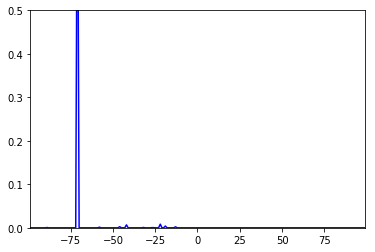

In [105]:
plt.plot(np.arange(-99,100), np.array(full_preds_df3[(full_preds_df3["gameId"] == 2018120210) & (full_preds_df3["playId"] == 3716)]["probability"]), 'b-')
plt.xlim(-99, 99)
plt.ylim(0,.5)
plt.show()

In [107]:
yac_data[(yac_data["gameId"] == 2018120210) & (yac_data["playId"] == 3716)].head(11)

,group,gameId,playId,defense_nflId,offense_nflId,playId3,playId2,defenseId,offenseId,defense_s_x,...,defense_offense_x,defense_offense_y,defense_offense_s_x,defense_offense_s_y,receiver_s_x,receiver_s_y,receiver_distance_from_los,defense_football_x,defense_football_y,football_s
1000230,training,2018120210,3716,2495493,89758,8242,5776,1,1,-4.035606,...,-3.47,-4.46,-0.434977,3.797374,2.03838,-4.499845,6.62,-17.22,12.03,12.78
1000231,training,2018120210,3716,2495493,2532899,8242,5776,1,2,-4.035606,...,-10.41,12.81,-5.098567,5.688751,2.03838,-4.499845,6.62,-17.22,12.03,12.78
1000232,training,2018120210,3716,2495493,2543499,8242,5776,1,3,-4.035606,...,2.28,1.65,2.087302,1.810437,2.03838,-4.499845,6.62,-17.22,12.03,12.78
1000233,training,2018120210,3716,2495493,2550400,8242,5776,1,4,-4.035606,...,-11.47,-3.79,-4.726816,2.050588,2.03838,-4.499845,6.62,-17.22,12.03,12.78
1000234,training,2018120210,3716,0,0,8242,5776,1,5,0.000000,...,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.00,0.00,0.00
1000235,training,2018120210,3716,0,0,8242,5776,1,6,0.000000,...,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.00,0.00,0.00
1000236,training,2018120210,3716,0,0,8242,5776,1,7,0.000000,...,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.00,0.00,0.00
1000237,training,2018120210,3716,0,0,8242,5776,1,8,0.000000,...,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.00,0.00,0.00
1000238,training,2018120210,3716,0,0,8242,5776,1,9,0.000000,...,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.00,0.00,0.00
1000239,training,2018120210,3716,0,0,8242,5776,1,10,0.000000,...,0.00,0.00,0.000000,0.000000,0.00000,0.000000,0.00,0.00,0.00,0.00
